# Execuçaõ do algoritimo de agrupamento K-means

- #### Execução e Comparação do SOM (Self-Organizing Maps)

In [ ]:
# Instale se necessário:
# !pip install minisom

from minisom import MiniSom
import pickle
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Carregar Dados


PROCESSANDO SOM: Original
Treinando SOM (10x10)...
Aplicando K-Means nos neurônios para forçar k=2...
Clusters Finais Gerados: 2
-> Silhouette Score: 0.8153


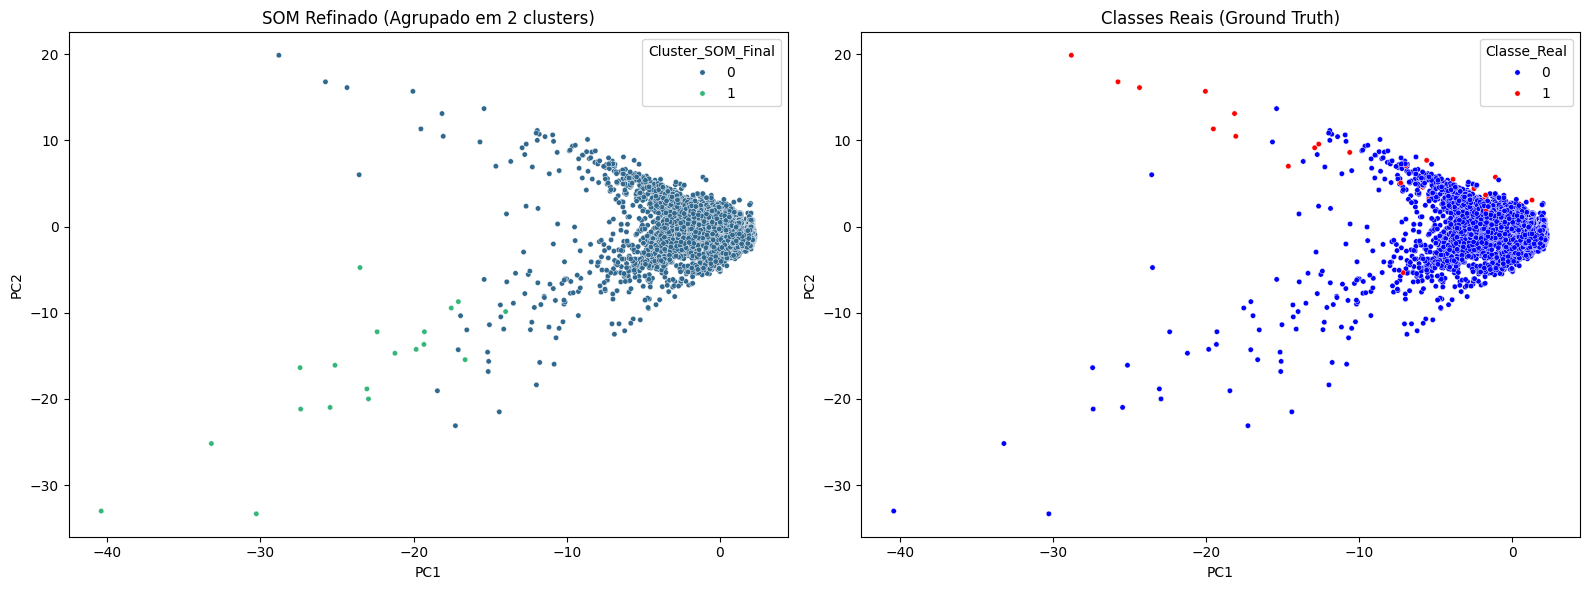


PROCESSANDO SOM: SMOTE (Over)
Treinando SOM (10x10)...
Aplicando K-Means nos neurônios para forçar k=2...
Clusters Finais Gerados: 2
-> Silhouette Score: 0.6565


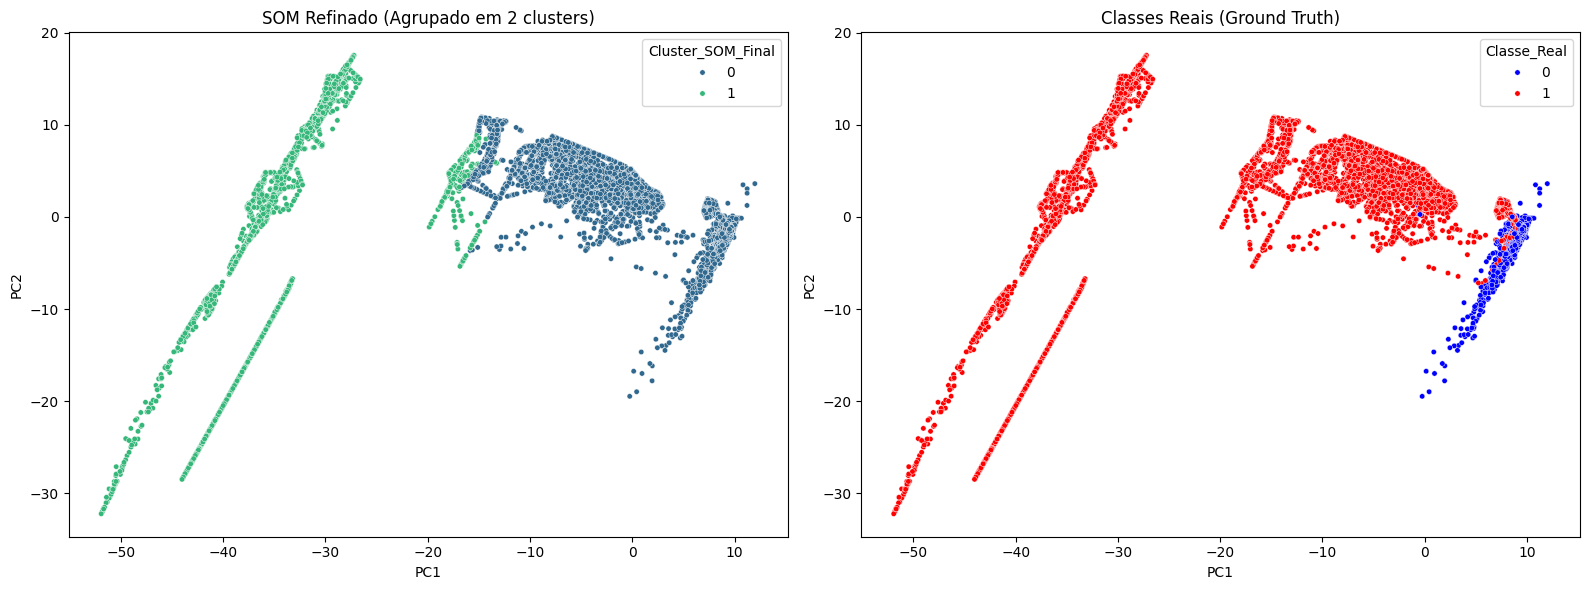


PROCESSANDO SOM: Under (NearMiss)
Treinando SOM (10x10)...
Aplicando K-Means nos neurônios para forçar k=2...
Clusters Finais Gerados: 2
-> Silhouette Score: 0.6341


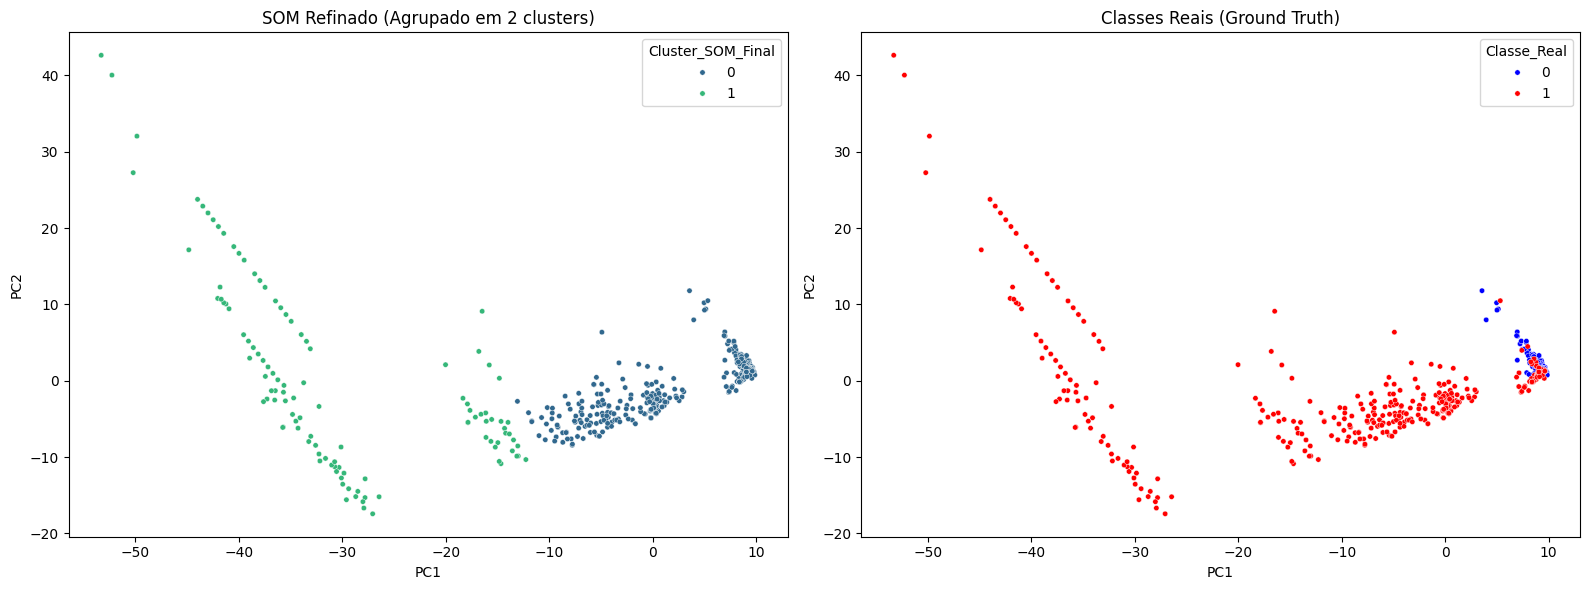


PROCESSANDO SOM: Combine (Over+Under)
Treinando SOM (10x10)...
Aplicando K-Means nos neurônios para forçar k=2...
Clusters Finais Gerados: 2
-> Silhouette Score: 0.6473


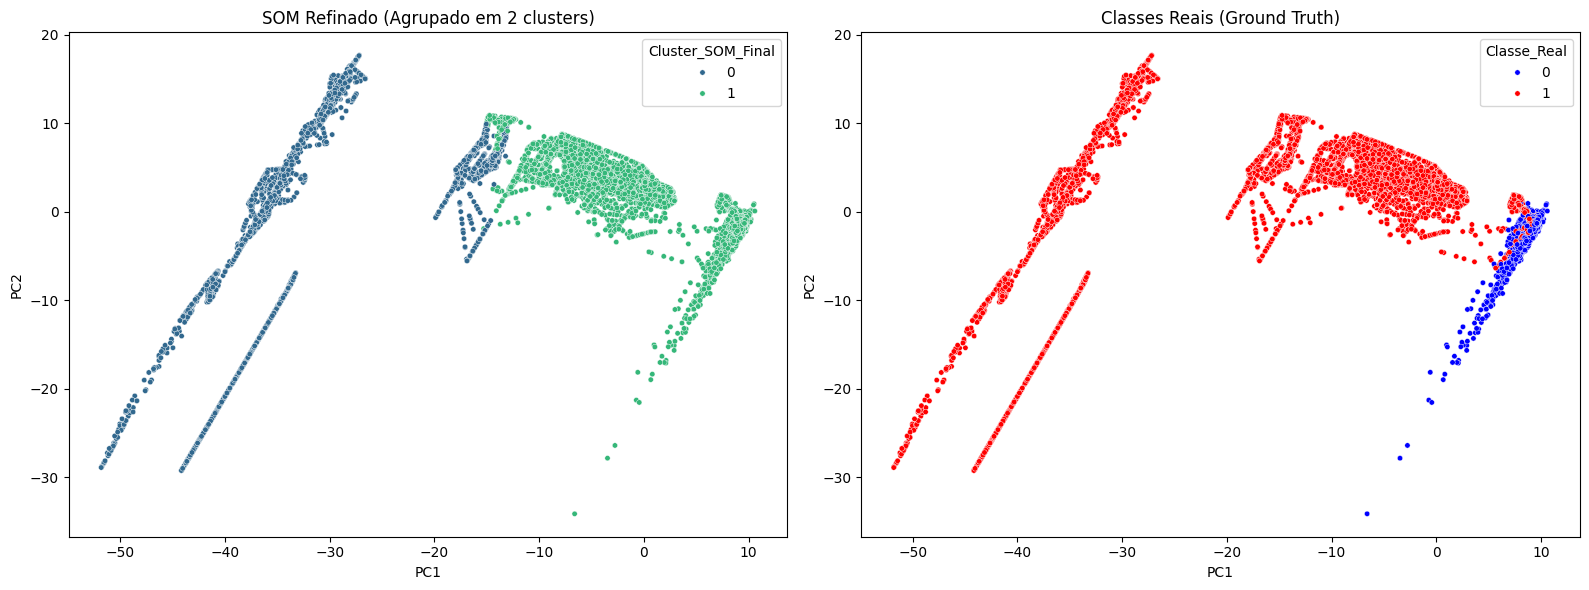


--- RESUMO FINAL SOM ---
                Dataset  Silhouette  Clusters
0              Original    0.815293         2
1          SMOTE (Over)    0.656518         2
2      Under (NearMiss)    0.634148         2
3  Combine (Over+Under)    0.647292         2


In [25]:
resultados_som = []

# Supõe que a variável 'datasets' já foi carregada anteriormente com seus 4 arquivos
# Caso não tenha carregado, rode o bloco de carregamento 'pickle.load' antes deste.

for nome_dataset, (X_train, y_train) in datasets.items():
    print(f"\n{'='*60}")
    print(f"PROCESSANDO SOM: {nome_dataset}")

    # 1. Preparação dos Dados
    # Converter para numpy array (MiniSom exige numpy, não Pandas)
    data = X_train.values if hasattr(X_train, 'values') else X_train
    
    # Amostragem para performance (se > 20k linhas)
    if data.shape[0] > 20000:
        idx = np.random.choice(data.shape[0], 20000, replace=False)
        data_train = data[idx]
        y_run = y_train.iloc[idx] if hasattr(y_train, 'iloc') else y_train[idx]
    else:
        data_train = data
        y_run = y_train

    # 2. Configurar e Treinar SOM
    # Usamos dim=10 (inteiro) para criar um mapa 10x10 (100 neurônios)
    # Isso permite espalhar bem os dados antes de agrupar.
    som_dim = 10 
    som = MiniSom(x=som_dim, y=som_dim, input_len=data_train.shape[1], sigma=1.0, learning_rate=0.5)
    
    som.random_weights_init(data_train)
    print("Treinando SOM (10x10)...")
    som.train_random(data_train, 10000) # 10 mil iterações

    # 3. O "Pulo do Gato": Clusterizar os Pesos dos Neurônios com K-Means
    # Objetivo: Transformar os 100 neurônios em apenas 2 grupos.
    print("Aplicando K-Means nos neurônios para forçar k=2...")
    
    weights = som.get_weights() # Pega os pesos (10, 10, n_features)
    weights_flat = weights.reshape(-1, weights.shape[2]) # Achata para (100, n_features)
    
    kmeans_som = KMeans(n_clusters=2, random_state=42, n_init='auto')
    # Classifica cada neurônio como pertencente ao grupo 0 ou 1
    neuron_clusters = kmeans_som.fit_predict(weights_flat)
    
    # Cria um mapa (matriz) onde cada posição diz se é cluster 0 ou 1
    label_map = neuron_clusters.reshape(som_dim, som_dim)

    # 4. Atribuir Rótulos Finais aos Dados
    # Para cada dado -> Acha o neurônio vencedor -> Vê qual cluster esse neurônio pertence
    labels_finais = []
    for x in data_train:
        w = som.winner(x)
        labels_finais.append(label_map[w[0], w[1]])
    
    labels_finais = np.array(labels_finais)
    n_clusters_ativos = len(set(labels_finais)) # Deve ser 2 agora
    print(f"Clusters Finais Gerados: {n_clusters_ativos}")

    # 5. Silhueta
    try:
        # Calcula a silhueta com base na divisão final (k=2)
        score = silhouette_score(data_train, labels_finais, sample_size=10000)
        print(f"-> Silhouette Score: {score:.4f}")
    except Exception as e:
        score = 0
        print(f"Erro na silhueta: {e}")

    resultados_som.append({'Dataset': nome_dataset, 'Silhouette': score, 'Clusters': n_clusters_ativos})

    # 6. Visualização
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(data_train)
    
    df_viz = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
    df_viz['Cluster_SOM_Final'] = labels_finais 
    df_viz['Classe_Real'] = y_run.values if hasattr(y_run, 'values') else y_run

    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    
    # Gráfico A: SOM Pós-Clusterizado (Deve mostrar 2 cores)
    sns.scatterplot(x='PC1', y='PC2', hue='Cluster_SOM_Final', data=df_viz, palette='viridis', s=15, ax=ax[0])
    ax[0].set_title(f'SOM Refinado (Agrupado em {n_clusters_ativos} clusters)')
    
    # Gráfico B: Realidade
    sns.scatterplot(x='PC1', y='PC2', hue='Classe_Real', data=df_viz, palette={0:'blue', 1:'red'}, s=15, ax=ax[1])
    ax[1].set_title('Classes Reais (Ground Truth)')
    
    plt.tight_layout()
    plt.show()

# Resumo Final
print("\n--- RESUMO FINAL SOM ---")
print(pd.DataFrame(resultados_som))


--- RESUMO COMPARATIVO DE PERFORMANCE (K-Means k=2) ---
                Dataset  Silhouette  Clusters
0              Original    0.815293         2
1          SMOTE (Over)    0.656518         2
3  Combine (Over+Under)    0.647292         2
2      Under (NearMiss)    0.634148         2


C:\Users\Cliente\AppData\Local\Temp\ipykernel_19344\2423197144.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Dataset', y='Silhouette', data=df_resultados, palette='magma')


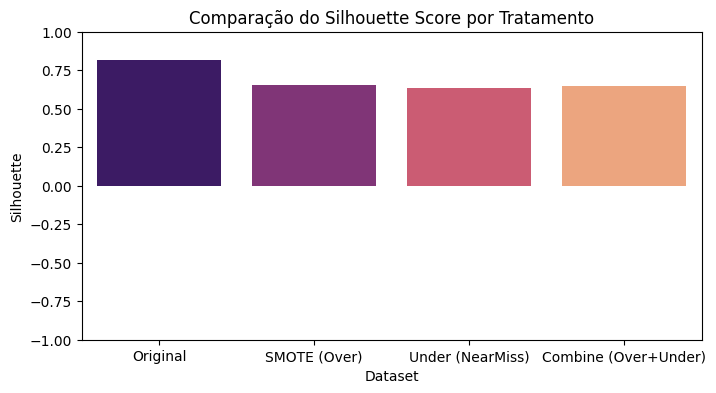

In [26]:
df_resultados = pd.DataFrame(resultados_som)
print("\n--- RESUMO COMPARATIVO DE PERFORMANCE (K-Means k=2) ---")
print(df_resultados.sort_values(by='Silhouette', ascending=False))

# Plotagem do gráfico de barras das silhuetas
if not df_resultados.empty:
    plt.figure(figsize=(8, 4))
    sns.barplot(x='Dataset', y='Silhouette', data=df_resultados, palette='magma')
    plt.title('Comparação do Silhouette Score por Tratamento')
    plt.ylim(-1, 1) # Silhouette varia de -1 a 1
    plt.show()